In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

In [4]:
democrat = pd.read_csv("LatinosForBiden.csv")
print(democrat.shape)
democrat.head(5)


(5075, 31)


,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,Love,...,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Interaction Rate,Interaction Rate (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )
0,TUCSON FOR BIDEN,NaN,365959221096173,855.0,2020-10-17 22:49:42 EDT,Photo,215,59,2,100,...,Hubby putting Biden signs on Valencia across f...,https://www.facebook.com/photo.php?fbid=133363...,NaN,NaN,Photos from Elisa Jaimez's post,NaN,NaN,NaN,44.56,44.56
1,AMERICA FOR BIDEN,NaN,371273317608123,234.0,2020-09-26 16:02:24 EDT,Photo,42,25,13,19,...,https://m.facebook.com/story.php?story_fbid=17...,https://www.facebook.com/FLDemocratsForOffice/...,NaN,NaN,FL Democrats For Office,Over 300+ cars in support of Joe Biden and Kam...,NaN,NaN,43.59,43.59
2,City of Tracy Republicans,NaN,390121591850924,3.0,2020-09-14 00:06:31 EDT,Photo,0,0,0,0,...,Wow. #Cornpop could have managed a better supp...,https://www.facebook.com/109624160595585/photo...,NaN,VOTE EARLY BID N HARRIS KMy,360 News Las Vegas,Only 4 Cars Showed Up today at The Latinos for...,NaN,NaN,33.33,33.33
3,CUBANOS FOR BIDEN,NaN,687544202026794,549.0,2020-09-14 23:36:59 EDT,Native Video,76,37,32,31,...,Brownsville Texas! Latinos for Biden 2️⃣0️⃣2️⃣...,https://www.facebook.com/groups/68754420202679...,NaN,NaN,NaN,NaN,NaN,NaN,32.24,32.24
4,REAL REPUBLICANS OF NEVADA,NaN,267207820990088,155.0,2020-09-13 18:14:20 EDT,Photo,8,4,6,1,...,Only 4 Cars Showed Up today at The Latinos for...,https://www.facebook.com/109624160595585/photo...,NaN,VOTE EARLY BID N HARRIS KMy,360 News Las Vegas,Only 4 Cars Showed Up today at The Latinos for...,NaN,NaN,30.32,30.32


In [8]:
democrat.columns

Index(['Group Name', 'User Name', 'Facebook Id', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Interaction Rate',
       'Interaction Rate (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'clean_url'],
      dtype='object')

In [9]:
message = democrat[['Message','Description']]
message

,Message,Description
0,Hubby putting Biden signs on Valencia across f...,NaN
1,https://m.facebook.com/story.php?story_fbid=17...,Over 300+ cars in support of Joe Biden and Kam...
2,Wow. #Cornpop could have managed a better supp...,Only 4 Cars Showed Up today at The Latinos for...
3,Brownsville Texas! Latinos for Biden 2️⃣0️⃣2️⃣...,NaN
4,Only 4 Cars Showed Up today at The Latinos for...,Only 4 Cars Showed Up today at The Latinos for...
...,...,...
5070,NaN,"America: Land of Opportunity for Every Race, D..."
5071,Biden wins more jobs in China and more money f...,NaN
5072,Our present may not have any big freind s or a...,NaN
5073,NaN,UFC fighter Jorge Masvidal gives one of the be...


In [10]:
content = message['Message'].fillna('') + (' ' + message['Description']).fillna('')

content = pd.DataFrame(content)
content.columns = ['Message']
content

,Message
0,Hubby putting Biden signs on Valencia across f...
1,https://m.facebook.com/story.php?story_fbid=17...
2,Wow. #Cornpop could have managed a better supp...
3,Brownsville Texas! Latinos for Biden 2️⃣0️⃣2️⃣...
4,Only 4 Cars Showed Up today at The Latinos for...
...,...
5070,"America: Land of Opportunity for Every Race, ..."
5071,Biden wins more jobs in China and more money f...
5072,Our present may not have any big freind s or a...
5073,UFC fighter Jorge Masvidal gives one of the b...


In [11]:
content['cleanMessage'] = content['Message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage']

0       Hubby putting Biden signs on Valencia across f...
1                                                        
2       Wow. #Cornpop could have managed a better supp...
3       Brownsville Texas! Latinos for Biden 2️⃣0️⃣2️⃣...
4       Only 4 Cars Showed Up today at The Latinos for...
                              ...                        
5070     America: Land of Opportunity for Every Race, ...
5071    Biden wins more jobs in China and more money f...
5072    Our present may not have any big freind s or a...
5073     UFC fighter Jorge Masvidal gives one of the b...
5074    Mr. President , Mr VP and Miss Kayleigh Congra...
Name: cleanMessage, Length: 5075, dtype: object

In [12]:
# Convert to list
data = content.cleanMessage.tolist()

In [13]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


## Tokenize words and Clean-up text

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['hubby', 'putting', 'biden', 'signs', 'on', 'valencia', 'across', 'from', 'the', 'latinos', 'for', 'trump', 'signs', 'lol', 'first', 'time', 'we', 'are', 'participating']]


## Creating Bigram and Trigram Models

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['hubby', 'putting', 'biden', 'signs', 'on', 'valencia', 'across', 'from', 'the', 'latinos', 'for', 'trump', 'signs', 'lol', 'first', 'time', 'we', 'are', 'participating']


## Remove Stopwords, Make Bigrams and Lemmatize


In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['hubby', 'put', 'biden', 'sign', 'valencia', 'latinos', 'trump', 'sign', 'lol', 'first', 'time', 'participate']]


## Bag of Words

In [18]:
from collections import Counter
flat_list_words = [item for sublist in data_words_nostops for item in sublist]
count_words = Counter(flat_list_words)
count_words.most_common(500)

[('trump', 10516),
 ('biden', 7851),
 ('latinos', 6250),
 ('de', 4989),
 ('joe', 3401),
 ('president', 3189),
 ('la', 3173),
 ('florida', 3107),
 ('que', 2884),
 ('el', 2709),
 ('en', 2515),
 ('voters', 1879),
 ('vote', 1737),
 ('people', 1602),
 ('los', 1517),
 ('latino', 1494),
 ('south', 1451),
 ('harris', 1416),
 ('black', 1299),
 ('americans', 1289),
 ('american', 1153),
 ('know', 1127),
 ('america', 1088),
 ('said', 1082),
 ('donald', 1048),
 ('por', 1039),
 ('kamala', 1031),
 ('anti', 1006),
 ('election', 1006),
 ('hispanic', 981),
 ('time', 974),
 ('campaign', 955),
 ('one', 945),
 ('miami', 926),
 ('con', 920),
 ('communist', 908),
 ('un', 900),
 ('cars', 899),
 ('del', 897),
 ('para', 895),
 ('democrats', 894),
 ('among', 893),
 ('news', 891),
 ('us', 891),
 ('caravan', 878),
 ('las', 845),
 ('support', 844),
 ('venezuela', 843),
 ('cuba', 823),
 ('democratic', 823),
 ('make', 819),
 ('socialism', 817),
 ('like', 811),
 ('white', 810),
 ('years', 807),
 ('would', 803),
 ('eve

## Create the Dictionary and Corpus needed for Topic Modeling

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1)]]


[[('biden', 1),
  ('first', 1),
  ('hubby', 1),
  ('latinos', 1),
  ('lol', 1),
  ('participate', 1),
  ('put', 1),
  ('sign', 2),
  ('time', 1),
  ('trump', 1),
  ('valencia', 1)]]

## Building the Topic Model

In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [21]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.301*"former" + 0.177*"medium" + 0.096*"conservative" + 0.052*"image" + '
  '0.035*"wait" + 0.028*"trust" + 0.020*"mainstream" + 0.016*"primary" + '
  '0.010*"flip" + 0.000*"white"'),
 (1,
  '0.377*"love" + 0.132*"participate" + 0.046*"pre" + 0.021*"dumb" + 0.012*"e" '
  '+ 0.008*"everywhere" + 0.008*"caravan" + 0.000*"world" + '
  '0.000*"ever_successful" + 0.000*"american"'),
 (2,
  '0.501*"trump" + 0.196*"biden" + 0.167*"latinos" + 0.073*"event" + '
  '0.013*"photo" + 0.010*"tag" + 0.009*"sign" + 0.001*"hat" + 0.000*"finger" + '
  '0.000*"white"'),
 (3,
  '0.612*"many" + 0.044*"penny" + 0.005*"floridafortrump" + 0.000*"white" + '
  '0.000*"pandemic" + 0.000*"leave" + 0.000*"live" + 0.000*"war" + '
  '0.000*"covid" + 0.000*"fact"'),
 (4,
  '0.511*"call" + 0.179*"rally" + 0.021*"train" + 0.018*"background" + '
  '0.009*"tank" + 0.008*"needed_sanity" + 0.008*"activism" + 0.006*"much" + '
  '0.001*"fakenew" + 0.000*"white"'),
 (5,
  '0.164*"roundtable" + 0.142*"abortion" + 0.07

## Compute Model Perplexity and Coherence Score


In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -18.82293522580965

Coherence Score:  0.34761133699789915


## Visualize the topics-keywords

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.313766  0.153462       1        1  20.258163
18     0.304316  0.222695       2        1  18.272013
2      0.244567  0.007925       3        1  13.560552
7      0.156538 -0.269462       4        1  10.071630
14     0.197073  0.112583       5        1   7.732407
10     0.113043 -0.207737       6        1   6.700165
8      0.117657 -0.115912       7        1   6.412799
15     0.113546 -0.161262       8        1   5.724689
19    -0.037476 -0.053716       9        1   2.610427
4     -0.083975  0.006803      10        1   1.346141
13    -0.058671  0.060988      11        1   1.328806
0     -0.108100 -0.011001      12        1   1.296379
6     -0.070970  0.034741      13        1   1.247152
3     -0.133499  0.016278      14        1   1.004426
1     -0.151175  0.023092      15        1   0.651208
12    -0.165368  0.027734      16        1   0.555617
16    -0.181239  0.032053      17        1   0.475950
5     -0.175063  0.030497      18        1   0.438686
9     -0.184324  0.052685      19        1   0.288817
11    -0.210647  0.037554      20        1   0.023980, topic_info=                  Term          Freq         Total Category  logprob  loglift
9                trump  13543.000000  13543.000000  Default  30.0000  30.0000
43                vote   5181.000000   5181.000000  Default  29.0000  29.0000
0                biden   5200.000000   5200.000000  Default  28.0000  28.0000
215              black   3144.000000   3144.000000  Default  27.0000  27.0000
3              latinos   4032.000000   4032.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
2647  attorney_general      0.005406      1.482046  Topic20  -8.9745   2.7220
2648         awareness      0.005406      1.482049  Topic20  -8.9745   2.7220
2649            battle      0.005406      1.482203  Topic20  -8.9745   2.7219
2650      battleground      0.005406      1.482191  Topic20  -8.9745   2.7219
2623            impede      0.005406      1.482050  Topic20  -8.9745   2.7220

[923 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
232      18  0.987261  abortion
63        1  0.959936    accord
63        5  0.038338    accord
292      10  0.951117  activism
64        1  0.996727        ad
...     ...       ...       ...
158       1  0.181291     would
158       2  0.797311     would
158       5  0.020811     would
182       1  0.193397      year
182       8  0.805966      year

[333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 19, 3, 8, 15, 11, 9, 16, 20, 5, 14, 1, 7, 4, 2, 13, 17, 6, 10, 12])

## Building LDA Mallet Model

In [24]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [25]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('cars_participate', 0.10277446300715991),
   ('thousand', 0.091736276849642),
   ('danger', 0.09024463007159904),
   ('event', 0.05205847255369928),
   ('trump', 0.03609785202863962),
   ('photo', 0.03326372315035799),
   ('tag', 0.027147971360381863),
   ('estimate', 0.02535799522673031),
   ('communist', 0.02133054892601432),
   ('campaign', 0.021032219570405727)]),
 (9,
  [('latinos', 0.14966634890371783),
   ('trump', 0.14553543056879567),
   ('event', 0.08214172227518271),
   ('latino', 0.07022561169367651),
   ('speak', 0.04130918334922148),
   ('state', 0.03701938353987925),
   ('rally', 0.02605656180489355),
   ('call', 0.023514458214172227),
   ('election', 0.017794725135049254),
   ('campaign', 0.017159199237368923)]),
 (2,
  [('vote', 0.149678191887442),
   ('trump', 0.043855710223020504),
   ('democratic', 0.02305044155066607),
   ('election', 0.019158808561592577),
   ('biden', 0.018410417602155366),
   ('people', 0.013920071845532105),
   ('latinos', 0.013171680

## Finding the optimal number of topics for LDA

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

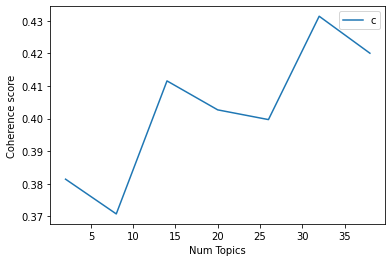

In [28]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3814
Num Topics = 8  has Coherence Value of 0.3707
Num Topics = 14  has Coherence Value of 0.4115
Num Topics = 20  has Coherence Value of 0.4027
Num Topics = 26  has Coherence Value of 0.3997
Num Topics = 32  has Coherence Value of 0.4314
Num Topics = 38  has Coherence Value of 0.42


In [30]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.070*"trump" + 0.057*"latinos" + 0.053*"event" + 0.033*"campaign" + '
  '0.026*"latino" + 0.023*"community" + 0.021*"biden" + 0.017*"call" + '
  '0.016*"hispanic" + 0.016*"today"'),
 (1,
  '0.011*"black" + 0.010*"people" + 0.009*"make" + 0.009*"political" + '
  '0.009*"party" + 0.008*"racist" + 0.007*"leader" + 0.007*"democratic" + '
  '0.007*"back" + 0.007*"leave"'),
 (2,
  '0.041*"voter" + 0.034*"vote" + 0.034*"biden" + 0.027*"trump" + '
  '0.026*"support" + 0.023*"percent" + 0.023*"latino" + 0.021*"state" + '
  '0.019*"poll" + 0.018*"election"'),
 (3,
  '0.057*"time" + 0.049*"black" + 0.049*"great" + 0.047*"trump" + '
  '0.035*"president" + 0.035*"american" + 0.024*"hispanic" + 0.023*"world" + '
  '0.021*"woman" + 0.021*"make"'),
 (4,
  '0.069*"trump" + 0.034*"vote" + 0.031*"biden" + 0.025*"country" + '
  '0.023*"people" + 0.017*"give" + 0.015*"child" + 0.011*"latinos" + '
  '0.011*"election" + 0.011*"plan"'),
 (5,
  '0.053*"biden" + 0.045*"cars_participate" + 0.040*"danger

##  Finding the dominant topic in each sentence

In [31]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1462,"time, black, great, trump, president, american...",Hubby putting Biden signs on Valencia across f...
1,1,0.0,0.1250,"trump, latinos, event, campaign, latino, commu...",
2,2,2.0,0.1549,"voter, vote, biden, trump, support, percent, l...",Wow. #Cornpop could have managed a better supp...
3,3,0.0,0.1250,"trump, latinos, event, campaign, latino, commu...",Brownsville Texas! Latinos for Biden 2️⃣0️⃣2️⃣...
4,4,0.0,0.1731,"trump, latinos, event, campaign, latino, commu...",Only 4 Cars Showed Up today at The Latinos for...
5,5,0.0,0.1915,"trump, latinos, event, campaign, latino, commu...",Biden a NO SHOW to his own event in Las Vegas ...
6,6,5.0,0.1745,"biden, cars_participate, danger, thousand, lat...",Latinos in South Florida love President Trump...
7,7,5.0,0.1843,"biden, cars_participate, danger, thousand, lat...",Miami TRUMP Caravan! 👍🇺🇸 #Cubans4Trump #Florid...
8,8,5.0,0.2399,"biden, cars_participate, danger, thousand, lat...","Miami PD Estimates More Than 30,000 Cars Parti..."
9,9,5.0,0.1745,"biden, cars_participate, danger, thousand, lat...",Latinos in South Florida love President Trump...


## Find the most representative document for each topic

In [32]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.7035   
1        1.0              0.7463   
2        2.0              0.7436   
3        3.0              0.8351   
4        4.0              0.7161   

                                                                           Keywords  \
0  trump, latinos, event, campaign, latino, community, biden, call, hispanic, today   
1    black, people, make, political, party, racist, leader, democratic, back, leave   
2        voter, vote, biden, trump, support, percent, latino, state, poll, election   
3      time, black, great, trump, president, american, hispanic, world, woman, make   
4         trump, vote, biden, country, people, give, child, latinos, election, plan   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [33]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"time, black, great, trump, president, american, hispanic, world, woman, make",1385.0,0.2729
1.0,0.0,"trump, latinos, event, campaign, latino, community, biden, call, hispanic, today",345.0,0.0680
2.0,2.0,"voter, vote, biden, trump, support, percent, latino, state, poll, election",539.0,0.1062
3.0,0.0,"trump, latinos, event, campaign, latino, community, biden, call, hispanic, today",232.0,0.0457
4.0,0.0,"trump, latinos, event, campaign, latino, community, biden, call, hispanic, today",296.0,0.0583
5.0,0.0,"trump, latinos, event, campaign, latino, community, biden, call, hispanic, today",1438.0,0.2833
6.0,5.0,"biden, cars_participate, danger, thousand, latinos, trump, communist, news, photo, video",491.0,0.0967
7.0,5.0,"biden, cars_participate, danger, thousand, latinos, trump, communist, news, photo, video",349.0,0.0688
